# Affective categorizaion of images with Gaussian noise defence

In [38]:
import tensorflow as tf
from PIL import Image
import glob
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers 
from tensorflow.keras import Model
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod
from art.estimators.classification import TensorFlowV2Classifier
import os

## Load data from Emotion6
source: http://chenlab.ece.cornell.edu/downloads.html

In [39]:
# load data from Emotion6 directiry
def get_images_and_labels(path):
    size = (128, 128)
    all_images = []
    image_names = []
    for filename in glob.glob(path + '*/*'):
        img = cv2.imread(filename)
        img = cv2.resize(img, size, interpolation=cv2.INTER_NEAREST)
        img = np.array(img)
        all_images.append(img.tolist())
        image_names.append(filename.replace(path, ''))
    return np.array(all_images), np.array(image_names)

In [40]:
X, Y = get_images_and_labels(os.getcwd() + ('\\Emotion6\\images\\' if os.name == 'nt' else '/Emotion6/images/'))

In [41]:
# change labels from image names to valence and arousal
# both are turned to binary to deal with class imbalance and small amount of data
def get_v_a_labels(y, path):
    all_labels = pd.read_csv(path + 'ground_truth.txt', delim_whitespace=True)
    if os.name == 'nt':
        all_labels['[image_filename]'] = all_labels['[image_filename]'].apply(lambda x: x.replace("/", "\\"))
    
    valence = []
    arousal = []
    for name in Y:
        # row of image
        row = all_labels.loc[all_labels['[image_filename]'] == name].values.tolist()[0]
        # change continous data to 0-9 score system
        valence.append(row[1] > 4.5)
        arousal.append(row[2] > 4.5)
    return np.array(valence), np.array(arousal)

In [42]:
valence, arousal = get_v_a_labels(Y, os.getcwd() + '\\Emotion6\\' if os.name == 'nt' else '/Emotion6/')

## Data preprocessing

In [43]:
# nomrmalization
X = X / 255.0

In [44]:
# join valence and arousal into matrix 2 x 2
joinedY = valence * 10 + arousal
for i in range(len(joinedY)):
    if joinedY[i] == 10:
        joinedY[i] = 2
    if joinedY[i] == 11:
        joinedY[i] = 3

In [45]:
# randomly shuffle data
shuffler = np.random.permutation(X.shape[0])

X = X[shuffler]
joinedY = joinedY[shuffler]

In [46]:
# split
X_train, X_test = np.split(X, [int(len(X) * 0.9)])
joinedY_train, joinedY_test = np.split(joinedY, [int(len(joinedY) * 0.9)])

In [47]:
# one-hot encoding
joinedY_train = tf.one_hot(joinedY_train, 4)
joinedY_test = tf.one_hot(joinedY_test, 4)

In [48]:
batch_size = 32
input_shape = (128, 128, 3)

## Inecptionv3
Use pretrained Inecptionv3 model

In [49]:
# load and freeze base model
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = input_shape, include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

In [50]:
# add custom layer
from tensorflow.keras.optimizers import RMSprop

x = layers.GaussianNoise(0.07)(base_model.output)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(4, activation='sigmoid')(x) # 4 - number of classes

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.00001), loss = 'binary_crossentropy', metrics = ['acc'])

In [51]:
inc_history = model.fit(X_train, joinedY_train, batch_size=batch_size, epochs=15, validation_split=0.3)

Epoch 1/15
39/39 [==============================] - 15s 320ms/step - loss: 0.7343 - acc: 0.3737 - val_loss: 0.6177 - val_acc: 0.4168
Epoch 2/15
39/39 [==============================] - 11s 296ms/step - loss: 0.5860 - acc: 0.4755 - val_loss: 0.5933 - val_acc: 0.4411
Epoch 3/15
39/39 [==============================] - 12s 297ms/step - loss: 0.5124 - acc: 0.5493 - val_loss: 0.5892 - val_acc: 0.4692
Epoch 4/15
39/39 [==============================] - 12s 306ms/step - loss: 0.4547 - acc: 0.5934 - val_loss: 0.5847 - val_acc: 0.4505
Epoch 5/15
39/39 [==============================] - 12s 308ms/step - loss: 0.4201 - acc: 0.6303 - val_loss: 0.5727 - val_acc: 0.4710
Epoch 6/15
39/39 [==============================] - 12s 309ms/step - loss: 0.3738 - acc: 0.6856 - val_loss: 0.5696 - val_acc: 0.4692
Epoch 7/15
39/39 [==============================] - 12s 310ms/step - loss: 0.3392 - acc: 0.7185 - val_loss: 0.5734 - val_acc: 0.4654
Epoch 8/15
39/39 [==============================] - 12s 306ms/step - 

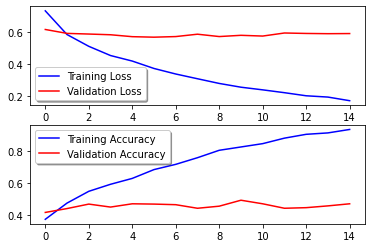

In [52]:
 # loss and accuracy curvers
fig, ax = plt.subplots(2,1)
ax[0].plot(inc_history.history['loss'], color='b', label="Training Loss")
ax[0].plot(inc_history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(inc_history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(inc_history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [53]:
# test model
test_loss, test_acc = model.evaluate(X_test, joinedY_test)

7/7 [==============================] - 1s 163ms/step - loss: 0.5485 - acc: 0.4899


## Inceptionv3 with full training

In [54]:
base_model = InceptionV3(input_shape = input_shape, include_top = False, weights = 'imagenet')

# add custom layer
from tensorflow.keras.optimizers import RMSprop

x = layers.GaussianNoise(0.07)(base_model.output)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(4, activation='sigmoid')(x) # 4 - number of classes

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.00001), loss = 'binary_crossentropy', metrics = ['acc'])

In [55]:
inc_history = model.fit(X_train, joinedY_train, batch_size=batch_size, epochs=25, validation_split=0.3)

Epoch 1/25
39/39 [==============================] - 53s 1s/step - loss: 0.5760 - acc: 0.4010 - val_loss: 0.6978 - val_acc: 0.4542
Epoch 2/25
39/39 [==============================] - 45s 1s/step - loss: 0.5226 - acc: 0.4643 - val_loss: 0.6031 - val_acc: 0.4561
Epoch 3/25
39/39 [==============================] - 44s 1s/step - loss: 0.4926 - acc: 0.5036 - val_loss: 0.6033 - val_acc: 0.4430
Epoch 4/25
39/39 [==============================] - 45s 1s/step - loss: 0.4745 - acc: 0.5261 - val_loss: 0.5469 - val_acc: 0.4579
Epoch 5/25
39/39 [==============================] - 45s 1s/step - loss: 0.4447 - acc: 0.5678 - val_loss: 0.5366 - val_acc: 0.4710
Epoch 6/25
39/39 [==============================] - 45s 1s/step - loss: 0.4202 - acc: 0.6095 - val_loss: 0.5363 - val_acc: 0.4729
Epoch 7/25
39/39 [==============================] - 45s 1s/step - loss: 0.4024 - acc: 0.6239 - val_loss: 0.5399 - val_acc: 0.4822
Epoch 8/25
39/39 [==============================] - 45s 1s/step - loss: 0.3744 - acc: 0.65

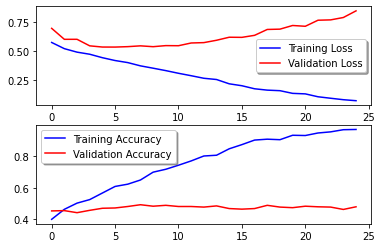

In [56]:
 # loss and accuracy curvers
fig, ax = plt.subplots(2,1)
ax[0].plot(inc_history.history['loss'], color='b', label="Training Loss")
ax[0].plot(inc_history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(inc_history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(inc_history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [57]:
# test model
test_loss, test_acc = model.evaluate(X_test, joinedY_test)

7/7 [==============================] - 1s 176ms/step - loss: 0.9246 - acc: 0.4394


In [58]:
# save model
model.save('images_gaussian_model.h5')

## Fast Gradient Sign Method attack

In [59]:
classifier = TensorFlowV2Classifier(
    model          = model,
    nb_classes     = 4,
    input_shape    = X[0].shape,
    loss_object    = tf.keras.losses.get("binary_crossentropy"),
    clip_values    = (0, 1),
    channels_first = False)

In [60]:
def perform_attack(attack, x_data, y_data):
    x_data_adv = attack.generate(x_data)
    
    y_data_predictions = np.argmax(classifier.model(x_data_adv), axis=1)
    accuracy_adv = np.sum(y_data_predictions == np.argmax(y_data)) / len(y_data)

    perturbation = np.mean(np.abs((x_data_adv - x_data)))

    print('Accuracy on adversarial test data: {}'.format(accuracy_adv))
    print('Average perturbation: {}'.format(perturbation))
    
    return x_data_adv, attack

def perform_fgsm_attack(classifier, x_data, y_data):
    attack = FastGradientMethod(estimator=classifier)
    return perform_attack(attack, x_data, y_data)

In [61]:
x_test_adv, attack = perform_fgsm_attack(classifier, X_test, joinedY_test)

Accuracy on adversarial test data: 0.1717171717171717
Average perturbation: 0.23451277263082917


After attack:
Prediction: 3 - 1 - 1:


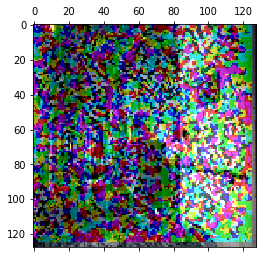

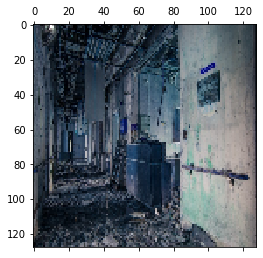

Prediction: 1 - 3 - 1:


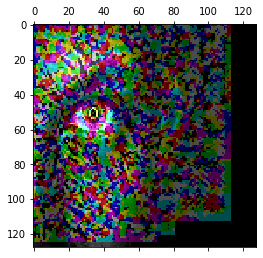

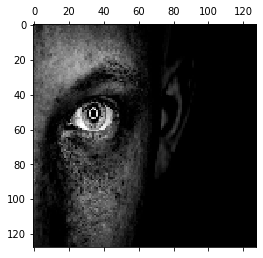

Prediction: 3 - 3 - 3:


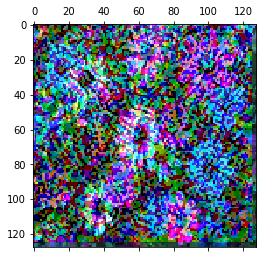

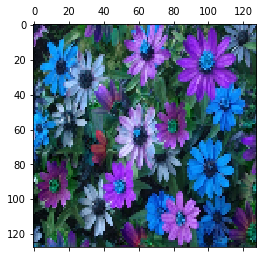

Prediction: 3 - 3 - 3:


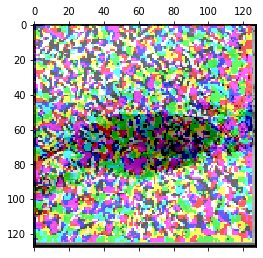

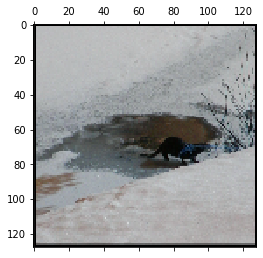

Prediction: 3 - 3 - 1:


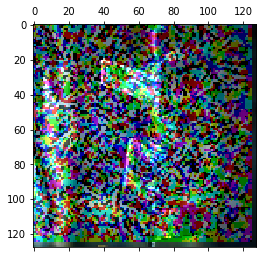

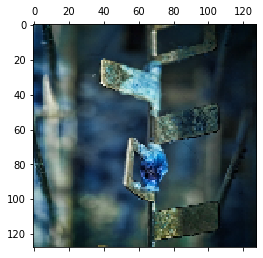

Prediction: 3 - 3 - 3:


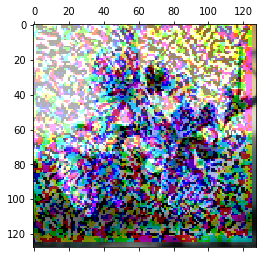

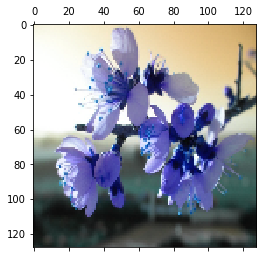

Prediction: 3 - 3 - 3:


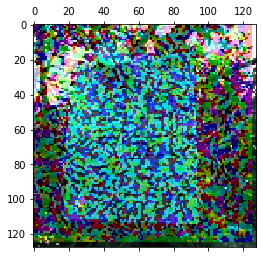

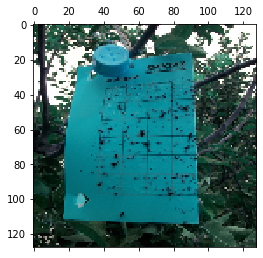

Prediction: 3 - 2 - 3:


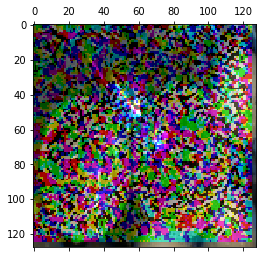

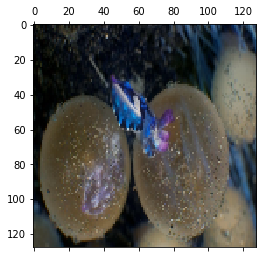

In [62]:
print('After attack:')

for i in range(8):
    prediction = np.argmax(classifier.model.predict(np.array([x_test_adv[i]])), axis=1)[0]
    prediction_model = np.argmax(classifier.model.predict(np.array([X_test[i]])), axis=1)[0]
    expected_y = np.argmax(joinedY_test[i])
    print('Prediction: {} - {} - {}:'.format(prediction, prediction_model, expected_y))

    plt.matshow(x_test_adv[i])
    plt.matshow(X_test[i])
    plt.show()

## Carlini & Wagner Infinity-norm attack

In [63]:
def perform_carlini_wagner_attack(classifier, x_data, y_data):
    attack = CarliniLInfMethod(classifier=classifier, 
                               max_iter=1, 
                               learning_rate=0.1, 
                               initial_const=1e0, 
                               largest_const=2e0)
    return perform_attack(attack, x_data, y_data)

In [64]:
x_test_adv, attack = perform_carlini_wagner_attack(classifier, X_test, joinedY_test)

C&W L_inf:   0%|          | 0/198 [00:00<?, ?it/s]

Accuracy on adversarial test data: 0.3838383838383838
Average perturbation: 0.018382160890685968


After attack:
Prediction: 0 - 1 - 1:


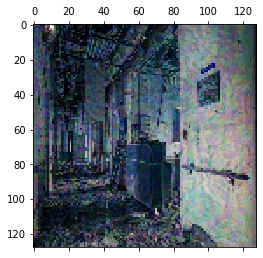

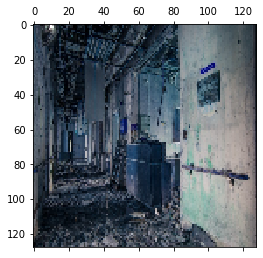

Prediction: 1 - 3 - 1:


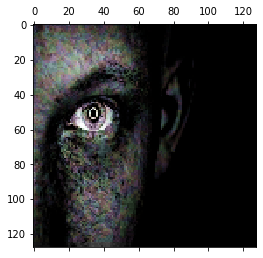

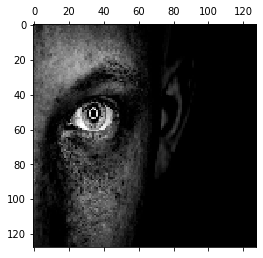

Prediction: 1 - 3 - 3:


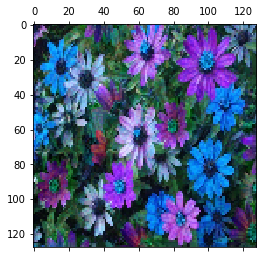

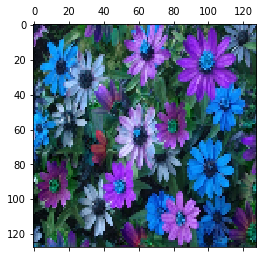

Prediction: 1 - 3 - 3:


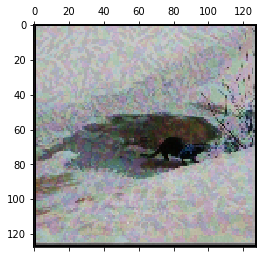

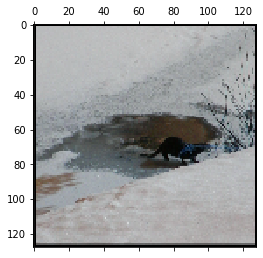

Prediction: 0 - 3 - 1:


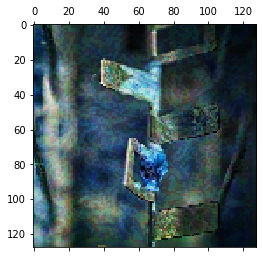

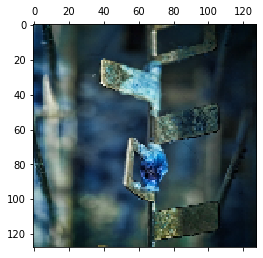

Prediction: 3 - 3 - 3:


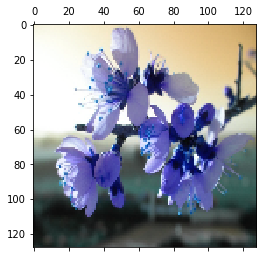

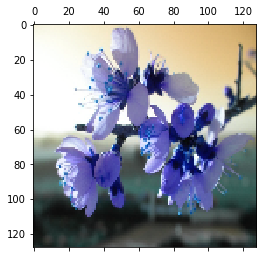

Prediction: 0 - 3 - 3:


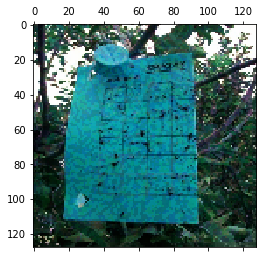

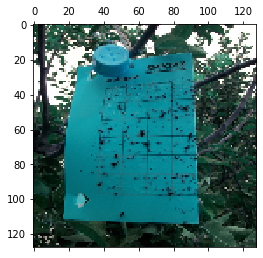

Prediction: 1 - 2 - 3:


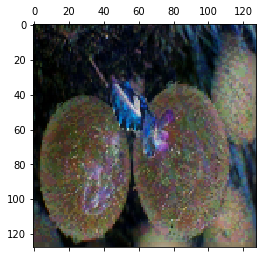

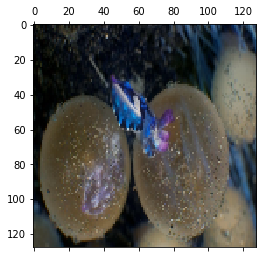

In [65]:
print('After attack:')

for i in range(8):
    prediction = np.argmax(classifier.model.predict(np.array([x_test_adv[i]])), axis=1)[0]
    prediction_model = np.argmax(classifier.model.predict(np.array([X_test[i]])), axis=1)[0]
    expected_y = np.argmax(joinedY_test[i])
    print('Prediction: {} - {} - {}:'.format(prediction, prediction_model, expected_y))

    plt.matshow(x_test_adv[i])
    plt.matshow(X_test[i])
    plt.show()

# Affective categorizaion of images with temperature defence

In [75]:
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(4, activation='relu')(x)


# Add a softmax layer for classification output
x = layers.Softmax()(x) # 4 - number of classes

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.00001), loss = 'binary_crossentropy', metrics = ['acc'])

In [76]:
inc_history = model.fit(X_train, joinedY_train, batch_size=batch_size, epochs=15, validation_split=0.3)

Epoch 1/15
39/39 [==============================] - 54s 1s/step - loss: 0.5622 - acc: 0.2382 - val_loss: 0.5617 - val_acc: 0.2486
Epoch 2/15
39/39 [==============================] - 45s 1s/step - loss: 0.5609 - acc: 0.3809 - val_loss: 0.5604 - val_acc: 0.4318
Epoch 3/15
39/39 [==============================] - 45s 1s/step - loss: 0.5594 - acc: 0.4242 - val_loss: 0.5593 - val_acc: 0.4318
Epoch 4/15
39/39 [==============================] - 45s 1s/step - loss: 0.5581 - acc: 0.4555 - val_loss: 0.5583 - val_acc: 0.4318
Epoch 5/15
39/39 [==============================] - 45s 1s/step - loss: 0.5568 - acc: 0.4587 - val_loss: 0.5574 - val_acc: 0.4318
Epoch 6/15
39/39 [==============================] - 45s 1s/step - loss: 0.5557 - acc: 0.4587 - val_loss: 0.5564 - val_acc: 0.4318
Epoch 7/15
39/39 [==============================] - 45s 1s/step - loss: 0.5547 - acc: 0.4587 - val_loss: 0.5555 - val_acc: 0.4318
Epoch 8/15
39/39 [==============================] - 45s 1s/step - loss: 0.5534 - acc: 0.45

In [ ]:
 # loss and accuracy curvers
fig, ax = plt.subplots(2,1)
ax[0].plot(inc_history.history['loss'], color='b', label="Training Loss")
ax[0].plot(inc_history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(inc_history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(inc_history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# test model
test_loss, test_acc = model.evaluate(X_test, joinedY_test)

## Inceptionv3 with full training

In [ ]:
base_model = InceptionV3(input_shape = input_shape, include_top = False, weights = 'imagenet')

# add custom layer
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(4, activation='relu')(x)
x = layers.Lambda(lambda x: x / 0.1)(x)

# Add a softmax layer for classification output
x = layers.Softmax()(x) # 4 - number of classes

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.00001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
inc_history = model.fit(X_train, joinedY_train, batch_size=batch_size, epochs=25, validation_split=0.3)

In [ ]:
 # loss and accuracy curvers
fig, ax = plt.subplots(2,1)
ax[0].plot(inc_history.history['loss'], color='b', label="Training Loss")
ax[0].plot(inc_history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(inc_history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(inc_history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# save model
model.save('images_temperature_model.h5')

## Attacks

In [ ]:
classifier = TensorFlowV2Classifier(
    model          = model,
    nb_classes     = 4,
    input_shape    = X[0].shape,
    loss_object    = tf.keras.losses.get("binary_crossentropy"),
    clip_values    = (0, 1),
    channels_first = False)

In [ ]:
x_test_adv, attack = perform_fgsm_attack(classifier, X_test, joinedY_test)

In [ ]:
print('After attack:')

for i in range(8):
    prediction = np.argmax(classifier.model.predict(np.array([x_test_adv[i]])), axis=1)[0]
    prediction_model = np.argmax(classifier.model.predict(np.array([X_test[i]])), axis=1)[0]
    expected_y = np.argmax(joinedY_test[i])
    print('Prediction: {} - {} - {}:'.format(prediction, prediction_model, expected_y))

    plt.matshow(x_test_adv[i])
    plt.matshow(X_test[i])
    plt.show()

In [ ]:
x_test_adv, attack = perform_carlini_wagner_attack(classifier, X_test, joinedY_test)

In [ ]:
print('After attack:')

for i in range(8):
    prediction = np.argmax(classifier.model.predict(np.array([x_test_adv[i]])), axis=1)[0]
    prediction_model = np.argmax(classifier.model.predict(np.array([X_test[i]])), axis=1)[0]
    expected_y = np.argmax(joinedY_test[i])
    print('Prediction: {} - {} - {}:'.format(prediction, prediction_model, expected_y))

    plt.matshow(x_test_adv[i])
    plt.matshow(X_test[i])
    plt.show()